# Исследование объявлений о продаже квартир

## Введение

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Наша задача — установить параметры, которые позволят построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Знакомство с данными

In [79]:
import pandas as pd
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [80]:
display(data.head())
print(data.info())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

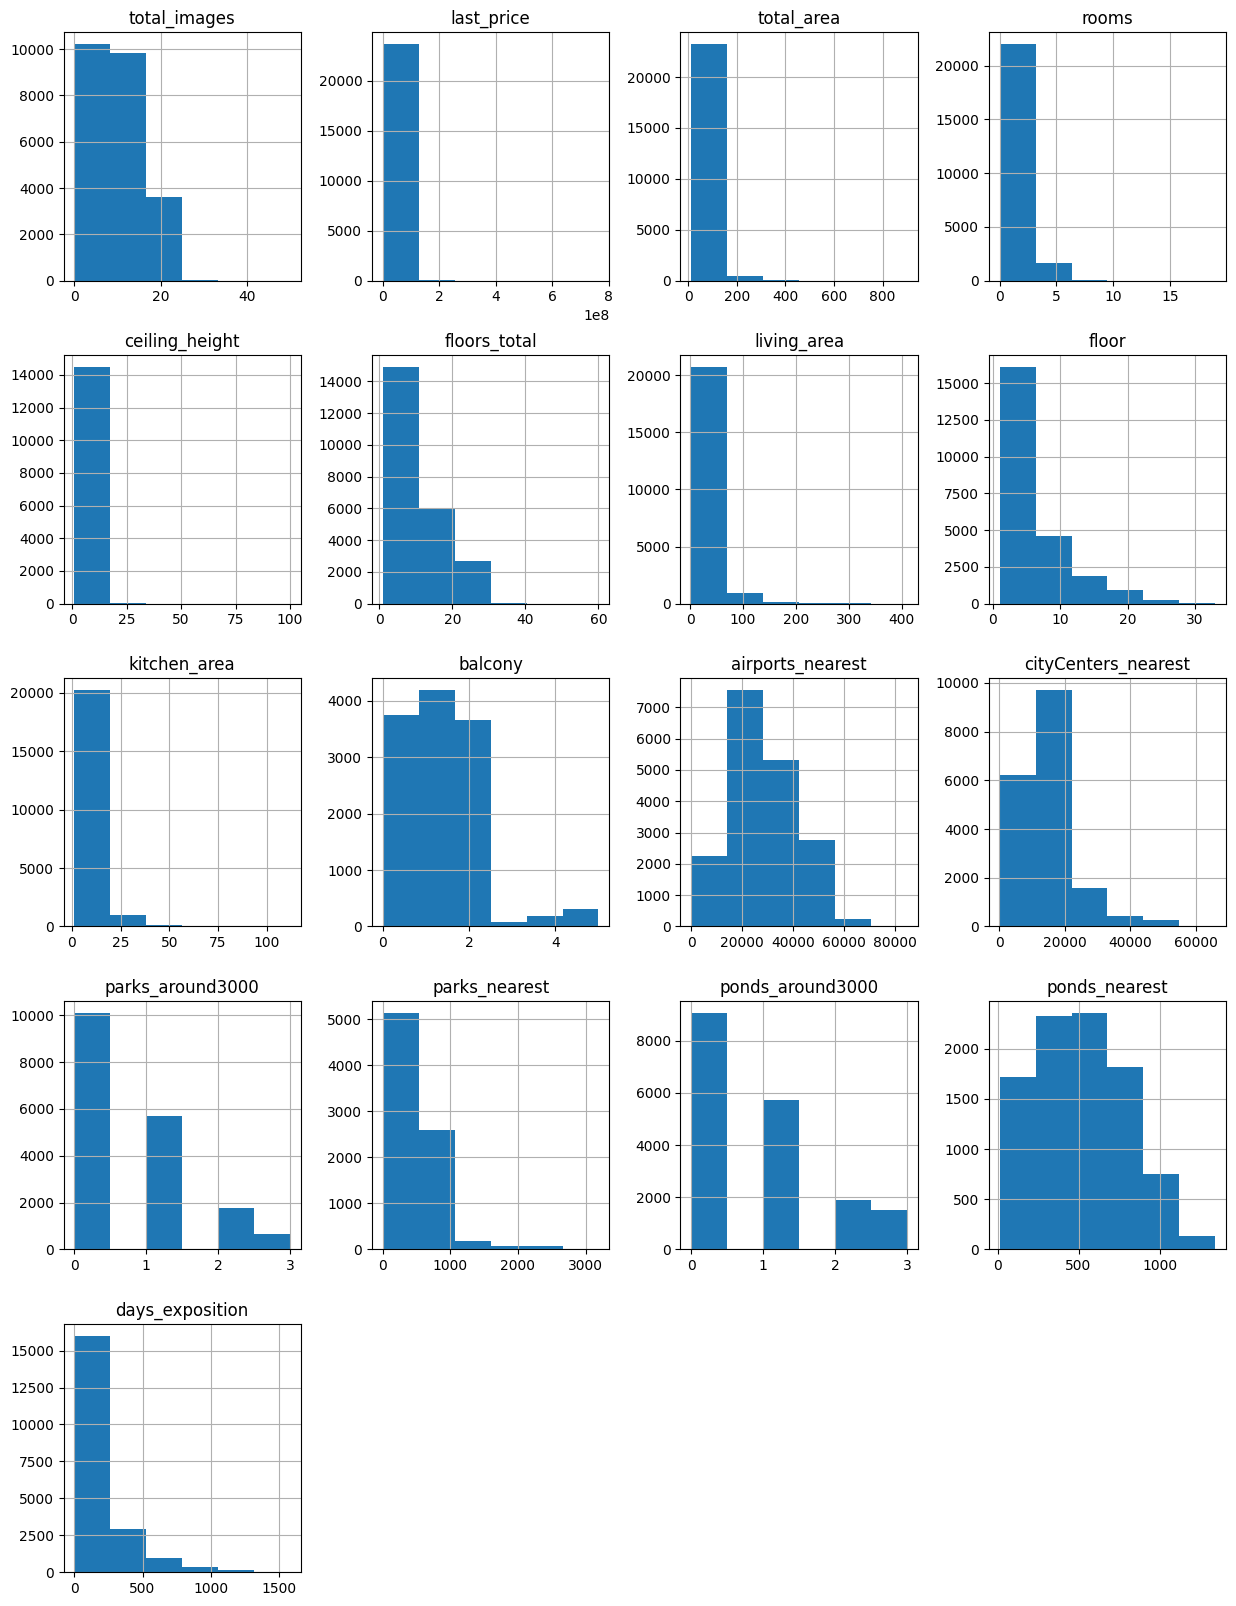

In [81]:
data.hist(figsize=(15, 20), bins=6);

По предварительным гистограммам наблюдаем, что практически все параметры отображаются некорректно из-за наличия в данных немногочисленных аномально-высоких значений, которые смещают график и делают его непоказательным. Прежде чем приступать к анализу, нам придется избавиться от подобных значений. \
Также в данных присутствует большое количество пропусков. Нам придется проанализировать их появление и исправить, где это возможно \
В свою очередь для корректной работы с данными, нам будет необходимо исправить неверный тип данных в некоторых столбцах

## Предобработка данных

### Изучаение и устранение пропусков в данных

In [82]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Пропуски присутствуют в следующих столбцах: \
**ceiling_height** - высота потолков (м) \
**floors_total** - всего этажей в доме \
**living_area** - жилая площадь в квадратных метрах (м²) \
**is_apartment** — апартаменты \
**kitchen_area** — площадь кухни в квадратных метрах (м²) \
**balcony** — число балконов \
**locality_name** — название населённого пункта \
**airports_nearest** — расстояние до ближайшего аэропорта в метрах (м) \
**cityCenters_nearest** — расстояние до центра города (м) \
**parks_around3000** — число парков в радиусе 3 км \
**parks_nearest** — расстояние до ближайшего парка (м) \
**ponds_around3000** — число водоёмов в радиусе 3 км \
**ponds_nearest** — расстояние до ближайшего водоёма (м) \
**days_exposition** — сколько дней было размещено объявление (от публикации до снятия)

Убрать пропуски в данных без искажения можно только в столбцах is_apartment, balcony, parks_around3000, ponds_around3000, заменив пропущенные значения нулями, поскольку пропуски в этих столбцах, скорее всего, означают, что объявление не обладает указанным атрибутом (не является аппартаментом, нет балкона и т.д.)

In [83]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

В остальных слобцах пропущенные значения либо не были указаны автором объявления, либо (как в столбцах с "расстоянием до...")  значение отсутствует по причине отсутсвия самого наличия указанного атрибута.

В дальнейшем, чтобы убрать аномальные значения из столбцов ceiling_height, living_area, kitchen_area и total_area, нам сперва нужно заполнить пропуски, иначе рискуем потерять значительную часть данных. Но прежде, чем заполнять пропуски медианными значениями, следует убедиться, что данные атрибуты не влияют, либо влияют не сильно на итоговую стоимость:

In [84]:
print('Корреляция между высотой потолка и стоимостью:')
print(data['ceiling_height'].corr(data['last_price']))
print('Корреляция между жилой площадью и стоимостью:')
print(data['living_area'].corr(data['last_price']))
print('Корреляция между площадью кухни и стоимостью:')
print(data['kitchen_area'].corr(data['last_price']))

Корреляция между высотой потолка и стоимостью:
0.085430309828426
Корреляция между жилой площадью и стоимостью:
0.5664915336952648
Корреляция между площадью кухни и стоимостью:
0.5198690130216388


Мы убедились, что высота потолка практически не влияет на итоговую стоимость, однако размер жилой и кухонной площади, хоть и не совсем линейно, но оказывает некоторое влияние на цену. Однако поскольку жилая и кухонная площадь входят в значение общей площади (total_area), а этот столбец у нас пропусков не имеет, замена пропущенных значений на медианные не окажет существенного влияния на качество данных.

In [85]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

### Анализ типов данных в столбцах

In [86]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,30.0,9,False,...,9.1,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Обнаружены столбцы, в которых необходимо изменить тип данных: \
**last_price** имеет тип данных float64, но поскольку содержит только цельные числа, имеет смысл изменить тип данных на int64 \
**first_day_exposition** отражает дату и время публикации, но имеет тип данных object, что следует привести к типу datetime/ Следует отметить, что оригинальные данные отражают только дату, а время публикации везде равно 0, поэтому при изменении типа данных были отброшены \
**is apartment** имеет тип данных object, хотя является булевым значением, отражающим, является ли объявление - апартаментом или нет \
**balcony, parks_around3000, ponds_around3000** следует поменять на int64, поскольку значения являются целым числом \
**airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, days_exposition** придется оставить float64, так как столбцы содержат пропуски, которые имеют тип данных float64 и не могут быть изменены или заполнены

In [87]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('bool')

for column in ['last_price', 'balcony', 'parks_around3000', 'ponds_around3000']:
    data[column] = data[column].astype('int')

### Устранение  неявных дубликатов в названиях населенных пунктов

In [88]:
data['locality_name'] = data['locality_name'].replace('ё', 'е', regex=True)
data['locality_name'] = data['locality_name'].replace('городской поселок', 'поселок городского типа', regex=True)
print(data['locality_name'].unique())

['Санкт-Петербург' 'поселок Шушары' 'поселок городского типа Янино-1'
 'поселок Парголово' 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'деревня Федоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'деревня Новое Девяткино'
 'поселок Металлострой' 'поселок городского типа Лебяжье'
 'поселок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок городского типа Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кал

Неявные дубликаты, возникшие из-за разности написания букв "е" и "ё", а так же из-за написания "городской поселок" вместо "поселок городского типа", были устранены

### Обработка аномальных значений

In [89]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699,23699.000000,23699.000000,23613.000000,23699.000000,23699.000000,23699.000000,23699.000000,18157.000000,18180.000000,23699.000000,8079.000000,23699.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2017-11-08 21:55:18.975484160,2.070636,2.724358,10.673824,34.099892,5.892358,10.428526,0.591080,28793.672193,14191.277833,0.469049,490.804555,0.590911,517.980900,180.888634
min,0.000000,1.219000e+04,12.000000,2014-11-27 00:00:00,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,2017-05-12 12:00:00,1.000000,2.600000,5.000000,19.000000,2.000000,7.400000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2017-12-12 00:00:00,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,0.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,2018-08-26 00:00:00,3.000000,2.700000,16.000000,41.100000,8.000000,11.440000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,2019-05-03 00:00:00,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.682529,1.088701e+07,35.654083,NaN,1.078405,0.988298,6.597173,21.162096,4.885249,5.631126,0.959298,12630.880622,8608.386210,0.748534,342.317995,0.883999,277.720643,219.727988


Аномально высокие или аномально низкие значения присутствуют в столбцах total_area, ceiling_height, living_area, kitchen_area \
Как правило, это квартиры с большим количеством комнат и общего пространства. Их не много, но они сильно влияют на общую картину. Столбец rooms, хоть он и имеет сверх высокие значения, мы трогать не будем, поскольку сверхбольшое количество комнат взаимосвязано со сверхбольшой площадью жилой, кухонной и общей зоны\
По формуле, позволяющей нам определить интервал нормальных значений, отсечем из данных по этим колонкам значения-выбросы. \
Сама формулы выглядит следующим образом: \


Но сначала нам стоит разобраться со столбцом ceiling_height, поскольку там много не просто больших, но нереалистичных значений. Вглянем на список уникальных значений:

In [90]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Данные в диапазоне от 20 до 32 выглядят как неверно записанные данные. Вполне вероятно, под ними подразумевались 2.0, 2.26, 2.4 и т.д. Исправим те данные, которые можно привести к реалистичным.

In [91]:
data['ceiling_height'] = data['ceiling_height'].replace([20., 22.6, 24., 25., 26., 27., 27.5, 32.], 
                                                        [2.0, 2.26, 2.4, 2.5, 2.6, 2.7, 2.75, 3.2], regex=True)

Теперь удалим аномальные значения из четырех столбцов (ceiling_height, total_area, living_area, kitchen_area). В качестве аномальных значений столбца ceiling_height исходя из здравого смысла определим значения меньше 2.4м (по ГОСТу) и больше 4м

In [92]:
data = data.query('ceiling_height <= 4').query('ceiling_height >= 2.4')
data = data.query('total_area <= 69.9 + (1.5 * (69.9 - 40))').query('total_area >= 40 - (1.5 * (69.9 - 40))')
data = data.query('living_area <= 42.3 + (1.5 * (42.3 - 18.6))').query('living_area >= 18.6 - (1.5 * (42.3 - 18.6))')
data = data.query('kitchen_area <= 12 + (1.5 * (12 - 7))').query('kitchen_area >= 7 - (1.5 * (12 - 7))')
data.reset_index(drop=True, inplace=True)

Выведем на экран обновленные данные и убедимся, что ликвидация выбросов произошла успешно.

In [93]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,21689.000000,2.168900e+04,21689.000000,21689,21689.000000,21689.000000,21611.000000,21689.000000,21689.000000,21689.000000,21689.000000,16312.000000,16330.000000,21689.000000,6914.000000,21689.000000,7911.000000,18976.000000
mean,9.718198,5.108562e+06,53.447526,2017-11-15 13:11:24.346904064,1.934713,2.674052,10.787007,30.714635,5.907787,9.329210,0.595832,28869.911047,14794.959645,0.428189,492.844084,0.543317,528.220579,173.625790
min,0.000000,4.300000e+05,12.000000,2014-11-27 00:00:00,0.000000,2.400000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.300000e+06,39.000000,2017-05-20 00:00:00,1.000000,2.600000,5.000000,18.700000,2.000000,7.000000,0.000000,18087.750000,10364.000000,0.000000,290.000000,0.000000,312.000000,44.000000
50%,9.000000,4.450000e+06,49.900000,2017-12-15 00:00:00,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,27011.500000,13485.500000,0.000000,457.000000,0.000000,514.000000,92.000000
75%,14.000000,6.100000e+06,64.000000,2018-08-28 00:00:00,3.000000,2.700000,16.000000,39.000000,8.000000,10.800000,1.000000,37499.000000,16603.000000,1.000000,616.750000,1.000000,736.000000,219.000000
max,39.000000,5.300000e+07,114.600000,2019-05-03 00:00:00,7.000000,4.000000,60.000000,77.800000,33.000000,19.500000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.564980,3.014919e+06,18.641060,NaN,0.898161,0.176605,6.620536,12.637680,4.899109,2.861529,0.949360,12917.622490,8498.330033,0.712900,338.286609,0.841987,276.613033,212.108322


Всего нам пришлось пожертвовать ~2 тысячами объявлений

### Добавление новых столбцов

Теперь для дальнейших вычислений нам необходимо добавить в таблицу новые столбцы со следующими параметрами: \
цена одного квадратного метра; \
день недели публикации объявления (0 — понедельник, 1 — вторник и так далее); \
месяц публикации объявления; \
год публикации объявления; \
тип этажа квартиры (значения — «первый», «последний», «другой»); \
расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [94]:
data['price_per_meter'] = data['last_price'] / data['total_area']
data['publication_weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

def floor_typing(row):
    if row['floor'] == 1:
         return 'первый'
    elif row['floor'] == row['floors_total']:
         return 'последний'
    else:
        return 'другой'
        
data['floor_type'] = data.apply(floor_typing, axis=1)
data['cityCenters_nearest_in_km'] = (data['cityCenters_nearest'] / 1000).round()

In [95]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,publication_weekday,publication_month,publication_year,floor_type,cityCenters_nearest_in_km
0,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
1,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
2,10,2890000,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,...,NaN,0,NaN,55.0,95065.789474,0,9,2018,другой,NaN
3,6,3700000,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,...,NaN,0,NaN,155.0,99195.710456,3,11,2017,другой,19.0
4,5,7915000,71.6,2019-04-18,2,2.65,24.0,30.0,22,False,...,NaN,0,NaN,NaN,110544.692737,3,4,2019,другой,12.0


## Исследовательский анализ данных

### Анализ всех параметров по отдельности

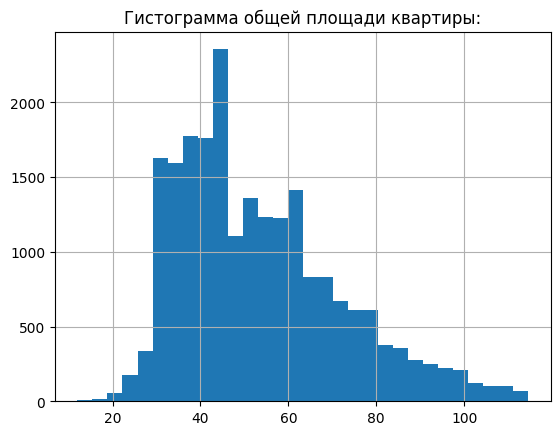

In [96]:
data['total_area'].hist(bins=30).set_title('Гистограмма общей площади квартиры:');

Пик количества объявлений приходится на квартиры с общей площадью ~45 м^2. В целом площадь большинства квартир варьируются в диапазоне 25-60 м^2, а далее наблюдается тенденция к снижению: чем больше площадь квартиры, тем меньше соответствующих объявлений

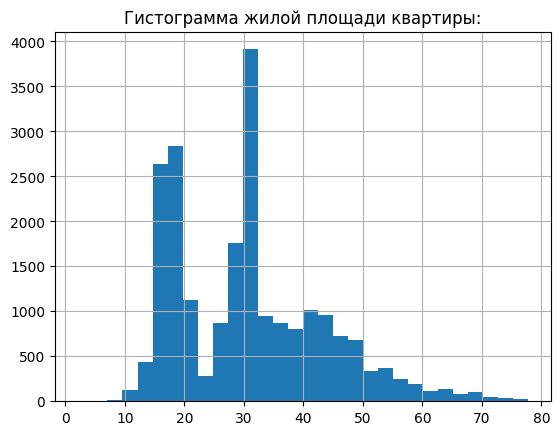

In [97]:
data['living_area'].hist(bins=30).set_title('Гистограмма жилой площади квартиры:');

Наблюдаются два пика: в районе 15-20 м^2 и в районе 30 м^2. Скорее всего эти пики отражают объяления о студиях и однокомнатных квартирах, что находится в соответствии с установленными нормами жилплощади однокомнатных квартир в 28 м^2, а также площадью одной комнаты в 14 м^2 (согласно СНиП)

Квартиры с кухонной площадью меньше 5 м^2:
103


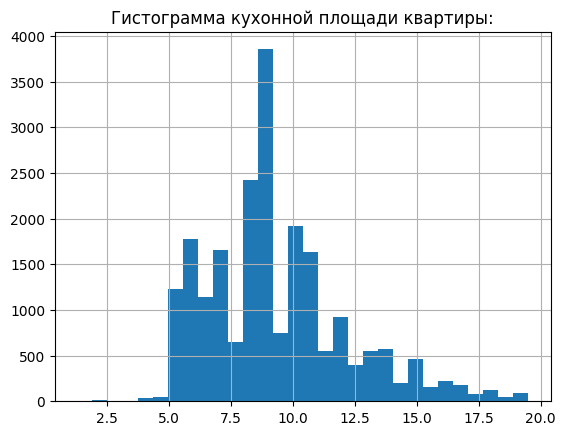

In [98]:
print('Квартиры с кухонной площадью меньше 5 м^2:')
print(data.query('kitchen_area < 5')['kitchen_area'].count())
data['kitchen_area'].hist(bins=30).set_title('Гистограмма кухонной площади квартиры:');

На гистограмме четко видно почти полное отсутствие квартир с площадью кухни меньше 5 м^2, что находится в полном соответствии со строительными нормами, по которым кухонная ниша не может занимать площадь меньше 5 м^2, однако существуют редкие исключения, при которых данное требование невыполнимо. Таких квартир в наших данных 103.

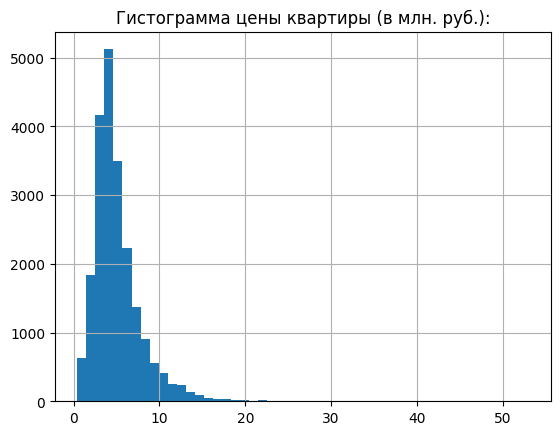

In [99]:
(data['last_price']/1000000).hist(bins=50).set_title('Гистограмма цены квартиры (в млн. руб.):');

Для корректного отображения гистограммы, цены на квартиры пришлось привести к миллионам. Как видим, крайне малое количество квартир стоят свыше 10 млн. Основной пик приходится на 3-5 млн.

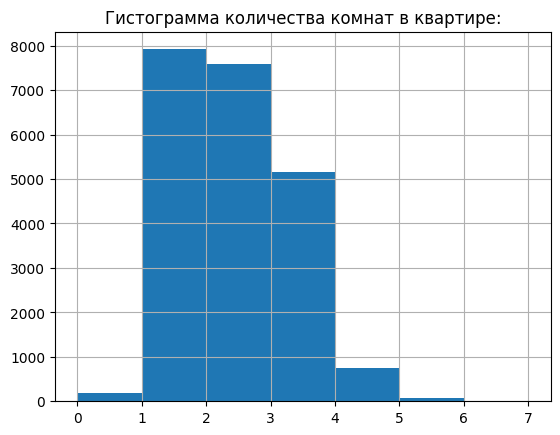

In [100]:
data['rooms'].hist(bins=7).set_title('Гистограмма количества комнат в квартире:');

Основная масса объявлений приходится на квартиры с 1-2 комнатами. Наличие в данных квартир с 0 комнат связано, вероятно, с тем, что так были обозначены квартиры-студии

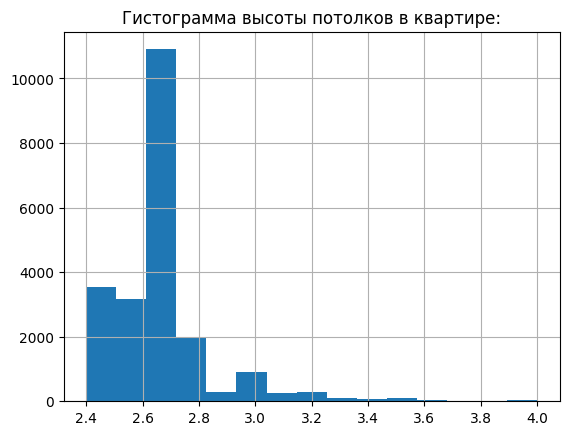

In [101]:
data['ceiling_height'].hist(bins=15).set_title('Гистограмма высоты потолков в квартире:');

Подавляющее большинство объявлений - это квартиры с высотой потолка 2.6 м, что является установленным средним показателем. Квартиры с потолком выше 3м - исключительно редкое явление

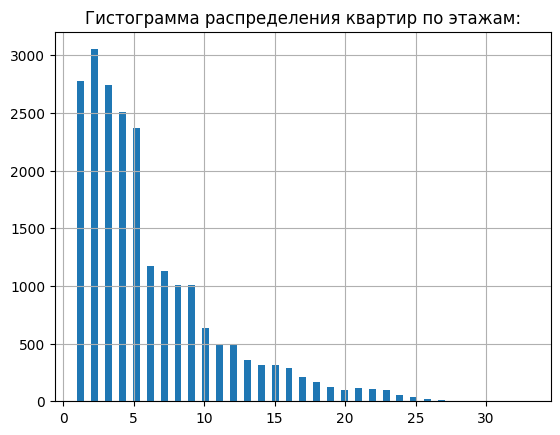

In [102]:
data['floor'].hist(bins=65).set_title('Гистограмма распределения квартир по этажам:');

Большинство объявлений - это квартиры на 1-5 этажах, что закономерно, учитывая, что в России очень много пятиэтажных домов (т.н. "Хрущёвки"), поэтому квартиры в них составляют значительную часть выборки

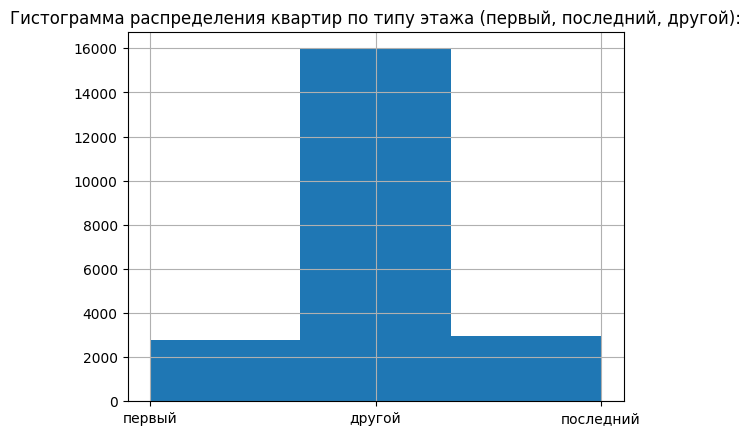

In [103]:
data['floor_type'].hist(bins=3).set_title('Гистограмма распределения квартир по типу этажа (первый, последний, другой):');

Данная гистограмма доказывает нам, что нет никакой зависимости между частотой объявлений квартир на первом или последнем этажах, количество соответствующих объявлений одинаково

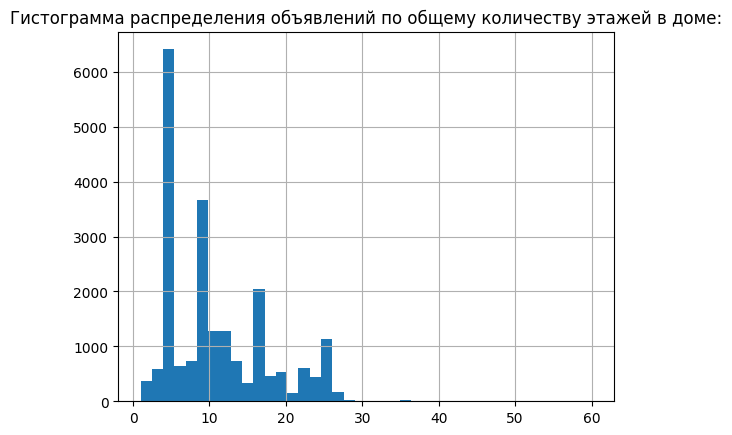

In [104]:
data['floors_total'].hist(bins=40).set_title('Гистограмма распределения объявлений по общему количеству этажей в доме:');

Как уже говорилось выше, значительную часть выборки составляют объявления в пятиэтажных домах, что объясняет пик в районе 5 этажей. Однако наблюдается и другой пик: дома с 9 этажами. Предполагаю, что это дома "брежневского типа", которые чаще всего имеют высоту в 9 этажей

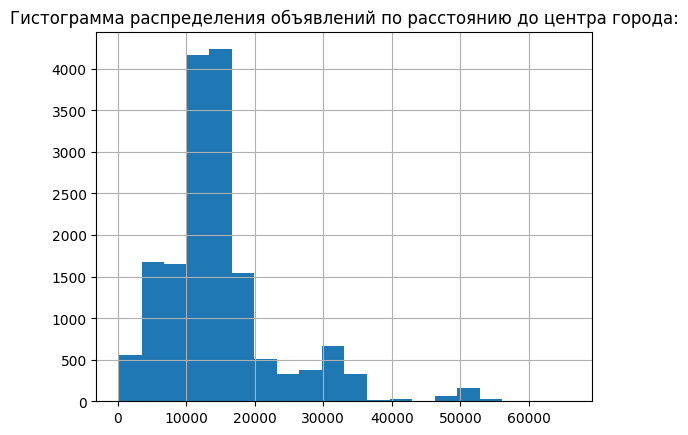

In [105]:
data['cityCenters_nearest'].hist(bins=20).set_title('Гистограмма распределения объявлений по расстоянию до центра города:');

Значительная часть квартир находятся на удалении 10-15 км от центра города. Объявления с удаленностью более 20 км редки и принадлежат квартирам из малых населенных пунктов

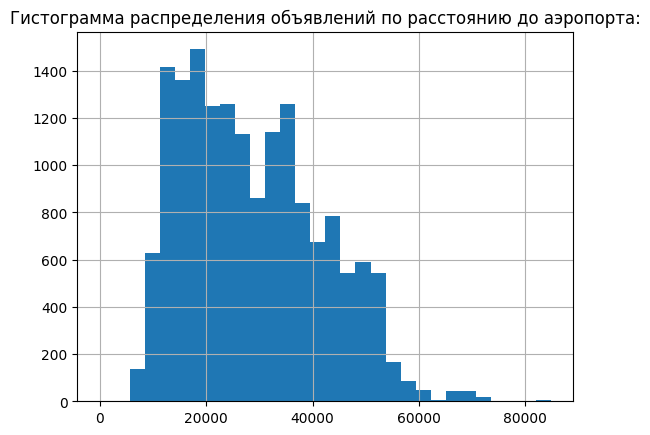

In [106]:
data['airports_nearest'].hist(bins=30).set_title('Гистограмма распределения объявлений по расстоянию до аэропорта:');

Среди тех объявлений, в которых расстояние было указано, большинство находится на удалении 15-35 км. Однако я предполагаю, что большинство объявлений, в которых не указано расстояние до аэропорта - это объявления из отдаленных малых населенных пунктов, поэтому, при отсутствии пропусков в данных, вид гистограммы мог бы измениться. Но пока мы можем судить лишь об объявлениях с указанным расстоянием.

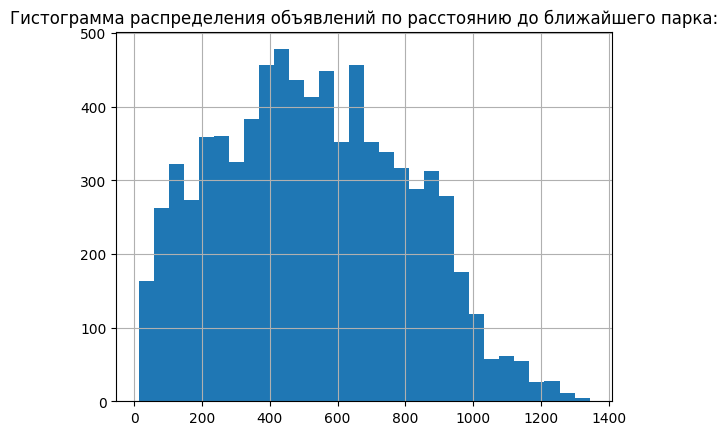

In [107]:
data['ponds_nearest'].hist(bins=30).set_title('Гистограмма распределения объявлений по расстоянию до ближайшего парка:');

Лишь чуть больше трети объявлений содержат данные о ближайшем парке, однако по их данным мы можем судить, что почти все из них находятся в пределах 1 километра от ближайшего парка.

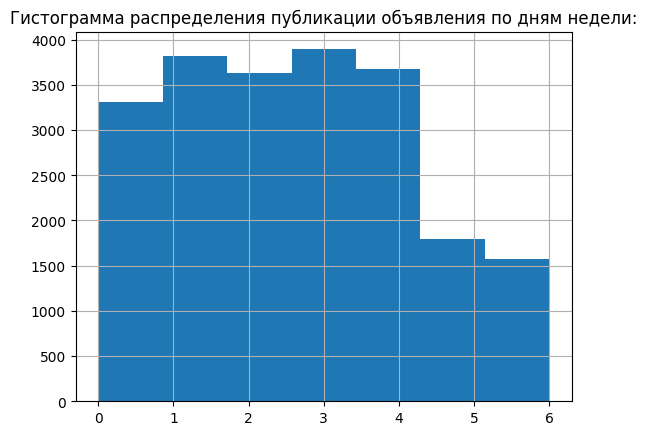

In [108]:
data['publication_weekday'].hist(bins=7).set_title('Гистограмма распределения публикации объявления по дням недели:');

В будние дни объявления публикают в два раза чаще, чем в выходные

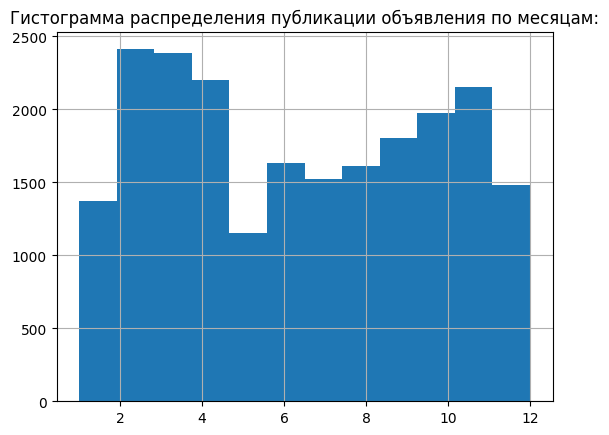

In [109]:
data['publication_month'].hist(bins=12).set_title('Гистограмма распределения публикации объявления по месяцам:');

Четкой взаимосвязи количества опубликованных объявлений от месяца к месяцу практически не наблюдается, за исключением резкого снижения в январе и мае, что, в совокупности с установленной связью количества объявлений от будних и выходных дней, наталкивает нас на мысль о том, что в эти два месяца уменьшение количества объявлений связано с большим количеством нерабочих праздничных дней

### Анализ быстроты продажи квартир

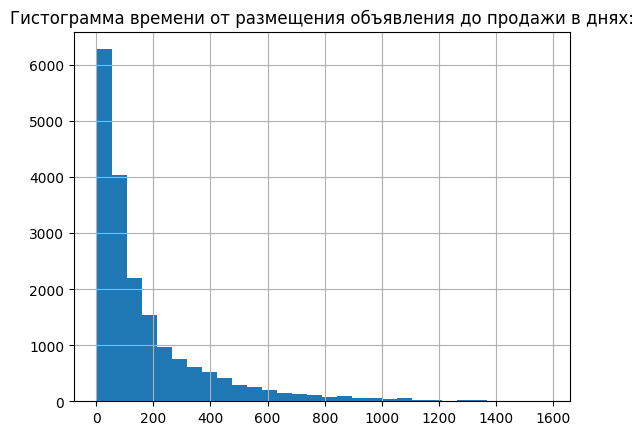

In [110]:
data['days_exposition'].hist(bins=30).set_title('Гистограмма времени от размещения объявления до продажи в днях:');

In [111]:
print('Среднее количество дней, за которое объявление было закрыто:', data['days_exposition'].mean().astype(int))
print('Медианное количество дней, за которое объявление было закрыто:', data['days_exposition'].median().astype(int))
print('Количество квартир, проданных менее чем за 100 дней:', data.query('days_exposition < 100')['days_exposition'].count())
print('Количество квартир, проданных более чем за 100 дней:', data.query('days_exposition >= 100')['days_exposition'].count())
print('Количество объявлений, висевших от года до двух:', data.query('(days_exposition >= 365) and (days_exposition <= 730)')['days_exposition'].count())
print('Количество объявлений, висевших более двух лет:', data.query('days_exposition > 730')['days_exposition'].count())
print('Количество квартир, проданных за месяц:', data.query('days_exposition <= 30')['days_exposition'].count())

Среднее количество дней, за которое объявление было закрыто: 173
Медианное количество дней, за которое объявление было закрыто: 92
Количество квартир, проданных менее чем за 100 дней: 9956
Количество квартир, проданных более чем за 100 дней: 9020
Количество объявлений, висевших от года до двух: 2018
Количество объявлений, висевших более двух лет: 629
Количество квартир, проданных за месяц: 3555


Как мы видим, половина всех проданных квартир была продана менее чем за 100 дней. Распределение остальных квартир неравномерно по времени и может быть очень растянуто, вплоть до нескольких лет. При этом довольно велико число объявлений, провисевших не более одного месяца (таких 3555), поэтому их можно считать самыми быстрыми объявлениями

### Анализ факторов, влияющих на полную стоимость квартиры

В этой части исследования, мы попробуем изучить зависимость цены от следующих факторов: \
общей площади; \
жилой площади; \
площади кухни; \
количества комнат; \
этажа, на котором расположена квартира (первый, последний, другой); \
даты размещения (день недели, месяц, год)

Корреляция между общей площадью квартиры и ее стоимостью:
0.6824661813616254


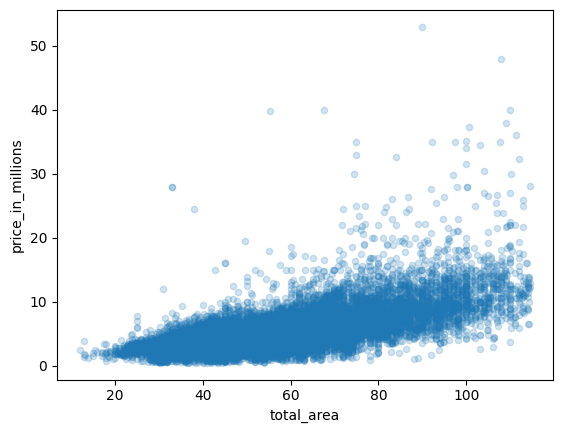

In [112]:
data['price_in_millions'] = data['last_price']/1000000
print('Корреляция между общей площадью квартиры и ее стоимостью:')
print(data['total_area'].corr(data['price_in_millions']))
data.plot(x='total_area', y='price_in_millions', kind='scatter', alpha=0.2);

Наблюдается определенная зависимость: с ростом общей площади квартиры растет и ее цена, хоть и не совсем линейно. Также на диаграмме рассеяния видны отдельные выпадающие точки - это квартиры, на цену которых сильно влияют прочие факторы (например удаленность от центра, наличие поблизости парков и др.)

Корреляция между жилой площадью квартиры и ее стоимостью:
0.540035099850989


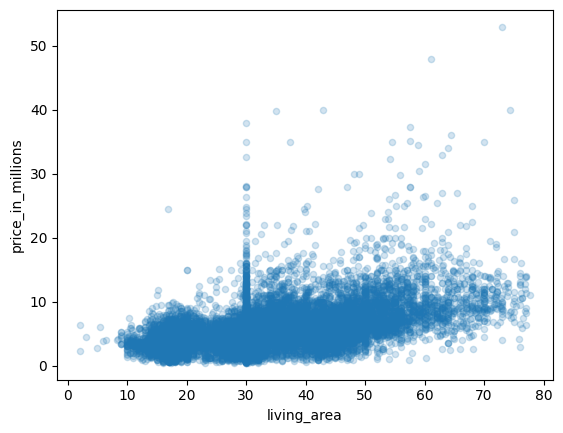

In [113]:
print('Корреляция между жилой площадью квартиры и ее стоимостью:')
print(data['living_area'].corr(data['price_in_millions']))
data.plot(x='living_area', y='price_in_millions', kind='scatter', alpha=0.2);

Данная зависимость значительно менее линейна, а в районе показателя в 30 м^2 наблюдается аномальный всплеск. Как обсуждалось выше, большая часть данных содержит объявления о продаже квартир именно с этой жилой площадью (что соответствует установленной минимальной жилой площади однокомнатных квартир). Всплеск на этом показателе еще раз демонстрирует большое количество этих объявлений и разницу в цене между ними, связанную с прочими факторами, влияющими на цену. \
Касательно общей более низкой корреляции необходимо заметить, что жилая площадь квартиры - это, по сути, под-фактор, входящий внутрь фактора общей площади.

Корреляция между кухонной площадью квартиры и ее стоимостью:
0.4537147028559192


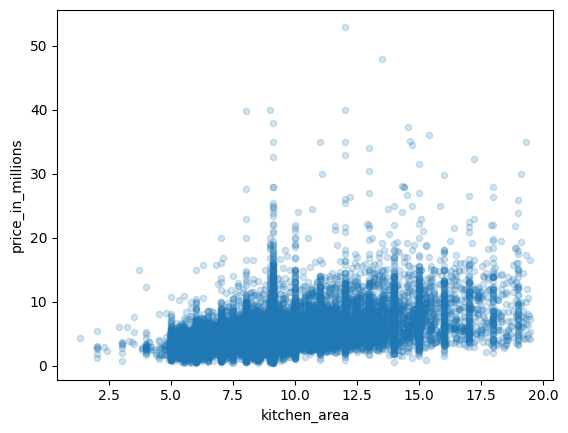

In [114]:
print('Корреляция между кухонной площадью квартиры и ее стоимостью:')
print(data['kitchen_area'].corr(data['price_in_millions']))
data.plot(x='kitchen_area', y='price_in_millions', kind='scatter', alpha=0.2);

Корреляция еще ниже, а диаграмма рассеяния содержит огромное количество всплесков, что наглядно демонстрирует нам, что кухонная площадь влияет на конечную стоимость значительно меньше других факторов, и не является основополагающей

Корреляция между количеством комнат в квартире и ее стоимостью:
0.4025876460228135


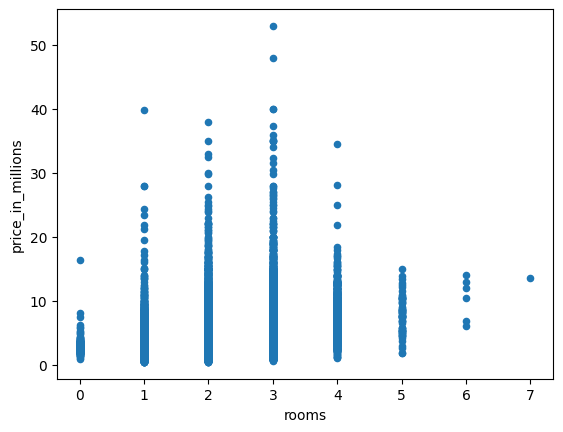

In [115]:
print('Корреляция между количеством комнат в квартире и ее стоимостью:')
print(data['rooms'].corr(data['price_in_millions']))
data.plot(x='rooms', y='price_in_millions', kind='scatter', alpha=1);

Четкой корреляции не наблюдается. И хотя на первый взгляд логично, что большее количество комнат => больше жилая площадь => больше общая площадь => больше цена, но наличие других факторов, влияющих на цену сильнее, чем количество комнат, не дают нам провести четкую корреляцию.

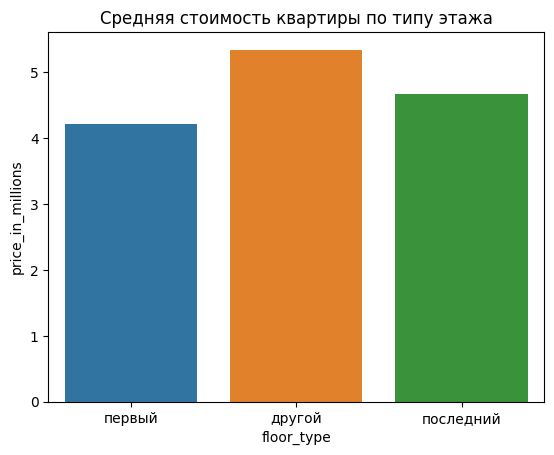

In [116]:
sb.barplot(x="floor_type", y="price_in_millions", data=data, ci= None).set_title('Средняя стоимость квартиры по типу этажа');

Представленный график позволяет нам сделать вывод, что первый и последний этажи в среднем имеют цену ниже, чем промежуточные, причем первый этаж дешевле последнего. И хотя, безусловно, другие факторы могут оказать существенное воздействие, в целом соответствующая корреляция существует

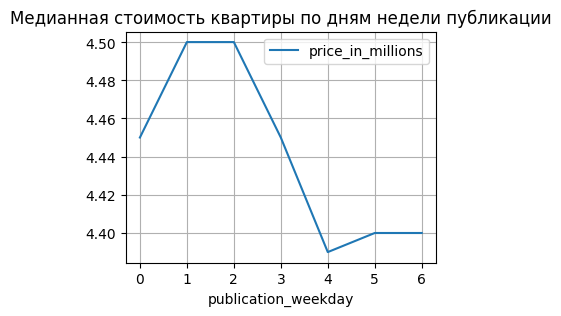

In [117]:
(data.pivot_table(index='publication_weekday', values='price_in_millions', aggfunc='median').plot(grid=True, figsize=(4,3))
 .set_title('Медианная стоимость квартиры по дням недели публикации'));

На графике видно, что в выходные дни публикуемые объявления дешевле, чем в будние, однако разница невелика (в среднем 100 тысяч)

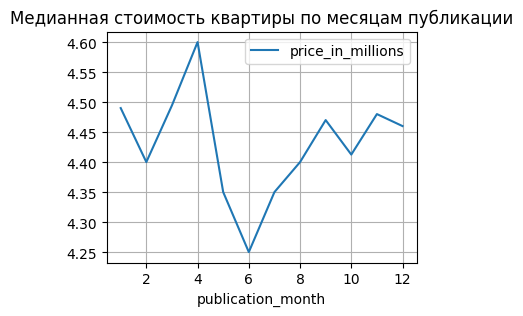

In [118]:
(data.pivot_table(index='publication_month', values='price_in_millions', aggfunc='median').plot(grid=True, figsize=(4,3))
.set_title('Медианная стоимость квартиры по месяцам публикации'));

На графике с медианной стоимостью квартир наблюдаются два пика: в апреле самая высокая медианная стоимость, в то время как в июне самая низкая. Разница между двумя пиками - 350 тысяч рублей, что заставляет нас зафиксировать данный факт в качестве интересной закономерности

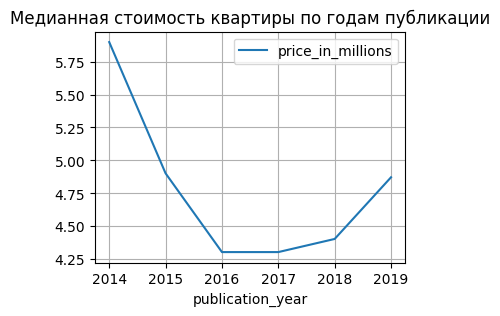

In [119]:
(data.pivot_table(index='publication_year', values='price_in_millions', aggfunc='median').plot(grid=True, figsize=(4,3))
.set_title('Медианная стоимость квартиры по годам публикации'));

На графике наблюдается аномальный пик в стоимости квартир в 2014 году, однако следует учесть, что данных за этот год крайне мало (всего 95 объявлений), как и за 2015 (1013 объявлений). В сумме они составляют менее 5% всех данных, поэтому учитывать их в общей закономерности некорректно. \
Взглянув на остальные года, мы видим тенденцию к увеличению цены, которая за 4 наблюдаемых года вырола в среднем более чем на 500 тысяч рублей. Вероятно, увеличение медианной стоимости квартир от года к году связано с явлением годовой инфляции.

### Подсчет средней стоимости одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [120]:
offers_in_city = data.groupby('locality_name')['price_per_meter'].count()
price_per_meter_in_city = data.groupby('locality_name')['price_per_meter'].mean().astype(int)
combined_data = pd.concat([offers_in_city, price_per_meter_in_city], axis= 1)
combined_data.columns = ['offers', 'price_per_meter']
combined_data.sort_values(by='offers', ascending=False).head(10)

,offers,price_per_meter
locality_name,,
Санкт-Петербург,13963,109163
поселок Мурино,550,85682
поселок Шушары,433,78704
Всеволожск,386,68515
Пушкин,333,100931
Колпино,332,75387
поселок Парголово,322,90185
Гатчина,301,68803
деревня Кудрово,283,92943


Мы получили данные по средней стоимости квадратного метра в десяти населенных пунктах с наибольшим числом объявлений. Среди них самая высокая стоимость квадратного метра в Санкт-Петербурге и Пушкине, а самая низкая - в Выборге, Всеволожске и Гатчине.

In [121]:
combined_data.sort_values(by='price_per_meter', ascending=False)

,offers,price_per_meter
locality_name,,
Санкт-Петербург,13963,109163
Зеленогорск,21,102890
Сестрорецк,161,102852
Пушкин,333,100931
поселок Лисий Нос,3,100660
...,...,...
поселок Совхозный,2,12629
деревня Выскатка,2,12335
деревня Вахнова Кара,1,11688


Среди всех городов в изначальных данных список с самой высокой стоимостью квадратного метра пополнили Зеленогорск, Сестрорецк и поселок Лисий нос. Среди населенных пунктов с самой низкой стоимостью квадратного метра оказался поселок Совхозный, деревни Выскатка, Вахнова Кара, Старополье, и поселок станции Свирь

#### Нахождение средней цены каждого километра в Санкт-Петербурге

In [122]:
SPB_data = data.query('locality_name == "Санкт-Петербург"')
price_to_distance = SPB_data.pivot_table(index='cityCenters_nearest_in_km', values='price_per_meter', aggfunc=['mean', 'median'])
price_to_distance

,mean,median
,price_per_meter,price_per_meter
cityCenters_nearest_in_km,,
0.0,146922.717598,109031.632653
1.0,150807.213766,126036.773684
2.0,138856.284371,120289.855072
3.0,117613.895053,108000.000000
4.0,125108.381510,117157.709188
5.0,131952.264085,125196.850394
6.0,130834.488065,121220.487433
7.0,130568.872709,117272.097195


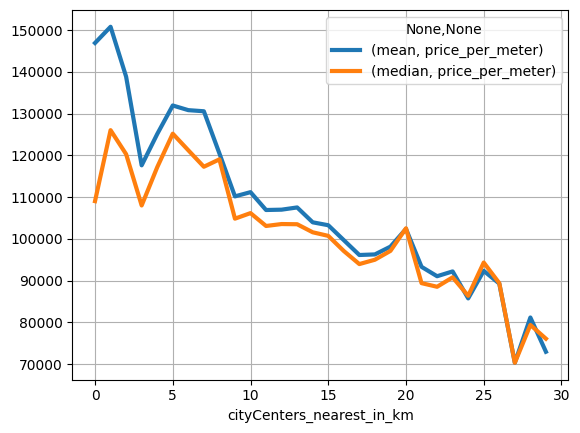

In [123]:
price_to_distance.plot(lw=3, grid=True);

На графике довольно четко видна почти прямая зависимость стоимости каждого квадратного метра в Санкт-Петербурге от удаленности от центра города: чем дальше от центра - тем дешевле каждый квадратный метр. Сильнее всего медианное и среднее значение отличаются на отрезке 0-2 км, что объясняется малой выборкой (таких объявлений всего 317 из 13963)

## Общий вывод

В данном исследовании основной целью было выявить **особенности** и **закономерности** рынка недвижимости в Санкт-Петербурге и соседних населенных пунктах. \
\
В ходе **предобработки данных** мы исправили неявные дубликаты в названиях некоторых населенных пунктов, а также избавились от объявлений с аномальными и выбивающимися значениями ради повышения качества анализа и нахождения именно характерных особенностей, на которые могли серьезно повлиять немногочисленные, но сильно выбивающиеся значения. Всего из 23699 объявлений мы убрали таким образом около 2000 объявлений. \
\
В **основной части** исследования мы изучили все основные параметры объявлений и сделали несколько заслуживающих внимания наблюдений: \
\
*1) Пик количества объявлений приходится на квартиры с общей площадью ~45 м^2. В целом площадь большинства квартир варьируются в диапазоне 25-60 м^2, а далее наблюдается тенденция к снижению: чем больше площадь квартиры, тем меньше соответствующих объявлений \
2) Подавляющее большинство объявлений стоят от 3 до 5 млн. руб. \
3) Основная масса объявлений приходится на квартиры с 1-2 комнатами \
4) Значительную часть составляют объявления в пятиэтажных и девятиэтажных домах \
5) Значительная часть квартир находятся на удалении 10-15 км от центра города. Объявления с удаленностью более 20 км редки и принадлежат квартирам из малых населенных пунктов \
6) В будние дни объявления публикают в два раза чаще, чем в выходные \
7) Меньше всего объявлений публикуется в январе и мае, что, в совокупности с установленной связью количества объявлений от будних и выходных дней, может свидетельствовать о том, что в эти два месяца уменьшение количества объявлений связано с большим количеством нерабочих праздничных дней \
8) Почти все закрытые объявления были закрыты в течение года, причем половина из них за первые три месяца* \
\
Анализируя различные **факторы**, влияющие на конечную **стоимость квартиры**, мы смогли прийти к некоторым ключевым выводам: \
\
*1) Основной фактор, влияющий на стоимость квартиры - общая площадь. Жилая и кухонная площадь, а так же количество комнат, хоть и являются составляющими фактора общей площади, но по отдельности оказывают на конечную стоимость гораздо меньшее влияние. \
2) Второй ключевой фактор стоимости квартиры - удаленность от центра города. С увеличением расстояния до центра уменьшается средняя стоимость каждого квадратного метра квартиры \
3) Квартиры на первом и последнем этажах в среднем дешевле, чем на промежуточных \
4) Стоимость квартиры незначительно зависит от дня недели публикации. Объявления, публикуемые в выходные в среднем дешевле на 100 тысяч \
5) Рассматривая зависимость цены от месяца, мы обнаружили два выбивающихся значения: в апреле наблюдается пик медианной стоимости квартир (4,6 млн. руб.), в то время как в июне наблюдается минимальная медианная стоимость (4,25 млн. руб.) \
6) От года к году медианная стоимость квартир растет, что, вероятно, связано с годовой инфляцией. В период с 2016 по 2019 год медианная стоимость выросла примерно на 500 тыс. руб. \
7) В Санкт-Петербурге - самый высокий показатель стоимости каждого квадратного метра площади (в среднем 109 тысяч / м^2)*